In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from diffusers import StableDiffusionInpaintPipeline
from diffusers import StableDiffusionXLInpaintPipeline

from PIL import Image
import numpy as np

import torch
from torchvision import transforms

# stable diffusion inpainting

In [2]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16, local_files_only=True
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


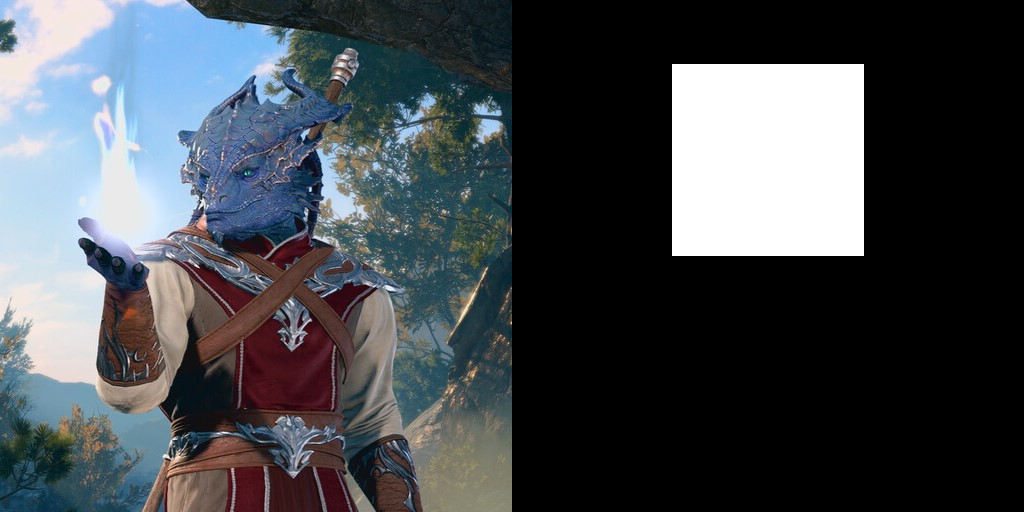

In [2]:
prompt = 'a handsome man with ray-ban sunglasses'

init_image = Image.open('./demo.jpg').convert("RGB").resize((512, 512))

mask = np.zeros((512, 512))
mask[64:256, 160:352] = 1
# mask[192:320, 192:320] = 1
mask = Image.fromarray(mask > 0).convert("RGB").resize((512, 512))

Image.fromarray(np.concatenate([np.array(init_image), np.array(mask)], axis=1))

  0%|          | 0/30 [00:00<?, ?it/s]

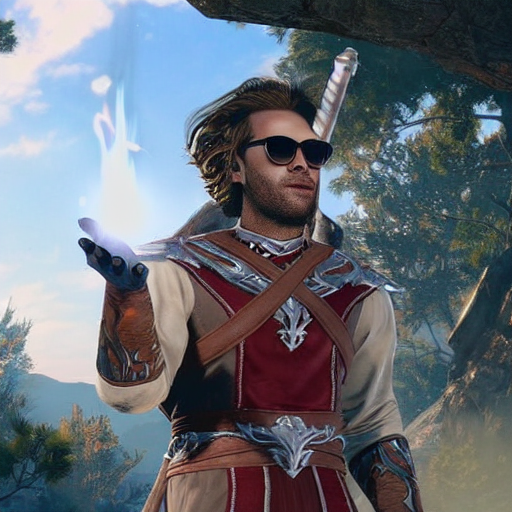

In [7]:
with torch.no_grad():
    image = pipe(
        prompt=prompt, image=init_image, mask_image=mask, num_inference_steps=40, strength=0.75, guidance_scale=7.5
    )
image.images[0]